## Figure 1 - Cheese3D accuracy

This notebook includes all the code necessary to reproduce Figure 1a and i.
To run this code, you need the following data:
- Anipose projects: `20231102-3D-structure-rig2`
- 3D scanner data

In [1]:
%load_ext autoreload
%autoreload 2

# Update path as if notebook was run from top-level repo directory
import os
import sys
pwd = %pwd
if not pwd.endswith('mouse-fe-analysis'):
    sys.path.insert(0, os.path.abspath('..'))
    new_pwd = os.path.abspath(f"{pwd}/..")
    %cd {new_pwd}

/Users/nozalma/repos/mouse-fe-analysis


/Users/nozalma/micromamba/envs/mouse-fe-analysis/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Preliminaries

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pathlib import Path

from fepipeline.features.landmarks import read_3d_data
from fepipeline.anatomy import compute_measurements_df
from labutils.plotting import (sns_setup, landmark_cmap, measurements_cmap) # You can define flat=true/false in landmark_cmap
from fepipeline.anatomy import compute_anatomical_measurements

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

# set seaborn theme
sns_setup("paper")
LANDMARK_CMAP = landmark_cmap()
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 10
plt.close()

### Step 0: read Cheese3D and 3D scan keypoint data

In [11]:
MICE_SHORT = ['B6', 'B15', 'B20', 'B21', 'B26', 'B31', 'B32', 'B33'] # mouse names
COORDINATE_PATHS_RIG2_6CAM = {}
ANIPOSE_BASE = './anipose-projects/20231102-3D-structure-rig2'

for p in Path(ANIPOSE_BASE).glob('*/pose-3d/*.csv'):
    mouse = p.name.split('_')[1]
    if mouse.startswith('B'): # a hack to get rid of phantom csv ._*.csv from mac
        condition = 'awake' if 'awake' in p.name else 'anes'
        COORDINATE_PATHS_RIG2_6CAM[(mouse, 'rig2', condition)] = p

mesh_dfs = []
for mesh_dir in ['./measurements-data/Watertight', './measurements-data/Watertight_area_volume']:
    for p in Path(mesh_dir).glob("*.csv"):
        mesh_dfs.append(pd.read_csv(p))
mesh_df = pd.concat(mesh_dfs)
mesh_df = mesh_df.rename(columns={
    'Mouse': 'mouse',
    'Source': 'source',
    'Measurement': 'measurement_name',
    'Value (mm)': 'measurement_value',
})
mesh_df = mesh_df[['mouse', 'source', 'measurement_name', 'measurement_value']]
coord_data_rig2_6cam = {k: read_3d_data(v.parent.parent.as_posix()) 
                        for k,v in COORDINATE_PATHS_RIG2_6CAM.items()}


### Step 1: Read 3D scan data

In [15]:
import glob
def read_3d_scan(data_dir):
    """Load 3D landmark data from Anipose.

    ### Arguments
    - `data_dir`: the Anipose directory for the 3d scan points to load

    ### Returns
    An array of 3D data where each row is a landmark containing
    the X, Y, Z coordinates determined through the 3D scan
    """
    data = pd.read_csv(data_dir)
    scan_coords = {} #landmark by (x,y,z)
    # print('This list of landmarks should follow the same order as the list above except the excluded points')
    for r in coord_data_rig2_6cam['B6','rig2','anes'].keys(): #Keys should be the same for every mouse
        for s in data['Point']:
            landmark_name = s
            if s == 'whiskerA(l)':
                landmark_name = 'pad(top)(left)'
            elif s == 'whiskerA(r)':
                landmark_name = 'pad(top)(right)'
            elif s == 'whiskerB(l)':
                landmark_name = 'pad(side)(left)'
            elif s == 'whiskerB(r)':
                landmark_name = 'pad(side)(right)'
            elif s == 'whiskerC':
                landmark_name = 'pad(center)'
            
            if landmark_name == r:
                #print(r)
                point = data.loc[data['Point'] == s, ['X', 'Y', 'Z']].values
                scan_coords[r] = point

    missing = ['lowerlip', 'upperlip(left)', 'upperlip(right)']
    for m in missing:
        if m not in scan_coords.keys():
            scan_coords[m] = np.zeros([1,3])

    return scan_coords


SCAN_DIRS = {mouse: f"./measurements-data/Watertight_coordinates/{mouse}_points_matrix_watertight.csv"
          for mouse in MICE_SHORT}

scan_coords = {(m, 'scan', 'anes'): read_3d_scan(SCAN_DIRS[m]) for m in MICE_SHORT}

### Step 2: Compute measurements (e.g., eye-width, ear-area, etc.) for Cheese3D and 3D-scan data

Note that these values are averages from the anesthetized period of the 'structure' experiment, where we recorded for a few minutes the mouse awake, and then anesthetized him with a ketamine-xylazine injection and recorded them again on the rig for a few minutes.

In [16]:
# Note that meas_df_rigX and mesh_df differ by the ref-point (3D-scan data does not have ref-point)
meas_df_rig2 = compute_measurements_df(coord_data_rig2_6cam)
mesh_df = compute_measurements_df(scan_coords)

In [18]:
# Uncomment this line to see how the dataframe for a mouse looks like
# meas_df_rig2.query("mouse == 'B6'")

In [31]:
# Merge all data into one dataframe:
cols = ['mouse', 'measurement_name', 'measurement_value']
rig2_and_mesh_df = pd.merge(meas_df_rig2.query("condition == 'anes'")[cols + ['measurement_type', 'measurement_units']], 
                            mesh_df[cols], 
                            on=['mouse', 'measurement_name'],
                            suffixes=['_rig2', '_mesh'])

rig2_and_mesh_df['abs-error'] = np.abs(rig2_and_mesh_df['measurement_value_mesh'] - rig2_and_mesh_df['measurement_value_rig2'])
rig2_and_mesh_df['rel-error'] = rig2_and_mesh_df['abs-error'] / rig2_and_mesh_df['measurement_value_mesh']
rig2_and_mesh_df.dropna()

,mouse,measurement_name,measurement_value_rig2,measurement_type,measurement_units,measurement_value_mesh,abs-error,rel-error
0,B15,nose-bulge-volume,9.046382,volume,mm^3,10.143243,1.096861,0.108137
1,B15,ear-area-left,86.321985,area,mm^2,74.057897,12.264088,0.165601
2,B15,ear-angle-right,166.728714,angle,deg,159.898730,6.829985,0.042714
3,B15,ear-angle-left,149.927042,angle,deg,152.760509,2.833467,0.018548
4,B15,ear-width-right,7.043054,distance,mm,6.235882,0.807173,0.129440
...,...,...,...,...,...,...,...,...
131,B6,eye-area-right,9.534975,area,mm^2,6.254686,3.280288,0.524453
132,B6,eye-area-left,9.915990,area,mm^2,5.805730,4.110261,0.707966
133,B6,eye-width-right,3.951752,distance,mm,2.945427,1.006325,0.341657
134,B6,eye-width-left,4.024904,distance,mm,3.079288,0.945616,0.307089


### Step 3: Import color-blind friendly color scheme

In [27]:
LANDMARK_CMAP_MEAS_OLD = measurements_cmap(spread = 0)

# Hardcode the ear angle & mouth area colors without changing the rest of colors
M_NAMES = {}
COLORS = {}
for i, s in enumerate(LANDMARK_CMAP_MEAS_OLD):
    if i == 0:
        for m, n in LANDMARK_CMAP_MEAS_OLD[i].items():
            M_NAMES[m] = n #hard-code the name
            if m == 'eye-width':
                M_NAMES['ear-angle'] = ["ear-angle-left",  "ear-angle-right"]
    else:
        for l,c in LANDMARK_CMAP_MEAS_OLD[i].items():
            COLORS[l] = c
            if l=='eye-width-right': # Specify where in the dictionary the colors are added
                COLORS['ear-angle-left'] = np.array([146, 114, 37, 255])/255 #Hard code ear angle color
                COLORS['ear-angle-right'] = np.array([146, 114, 37, 255])/255

LANDMARK_CMAP_MEAS = (M_NAMES, COLORS)
LANDMARK_CMAP_MEAS[1]['mouth-area'] = np.array([208, 105, 80, 255])/255 #Hard code mouth color

# Uncomment line below to see colormap dictionary structure
# display(LANDMARK_CMAP_MEAS)

## Panel a

1. First, compute the feature measurements for each timepoint. 

In [38]:
fps = 100 # Frames per second
mouse = 'B6' # Pick a mouse for the traces
totaltime = len(coord_data_rig2_6cam[(mouse, 'rig2', 'awake')]['ear(base)(left)'])/fps # Time length of the experiment
timev = np.linspace(0,totaltime,int(totaltime*fps)) # Time vector

meas_times_B6 = compute_anatomical_measurements(coord_data_rig2_6cam[('B6', 'rig2', 'awake')])

# Function to z-score measurement values using mean across time
def z_score(raw_data):
    mean = np.mean(raw_data, 0, keepdims=True)
    sigma = np.std(raw_data, 0, keepdims=True)
    #sigma[sigma == 0] = 1
    return (raw_data-mean)/sigma

2. Plot the feature traces in a given time window

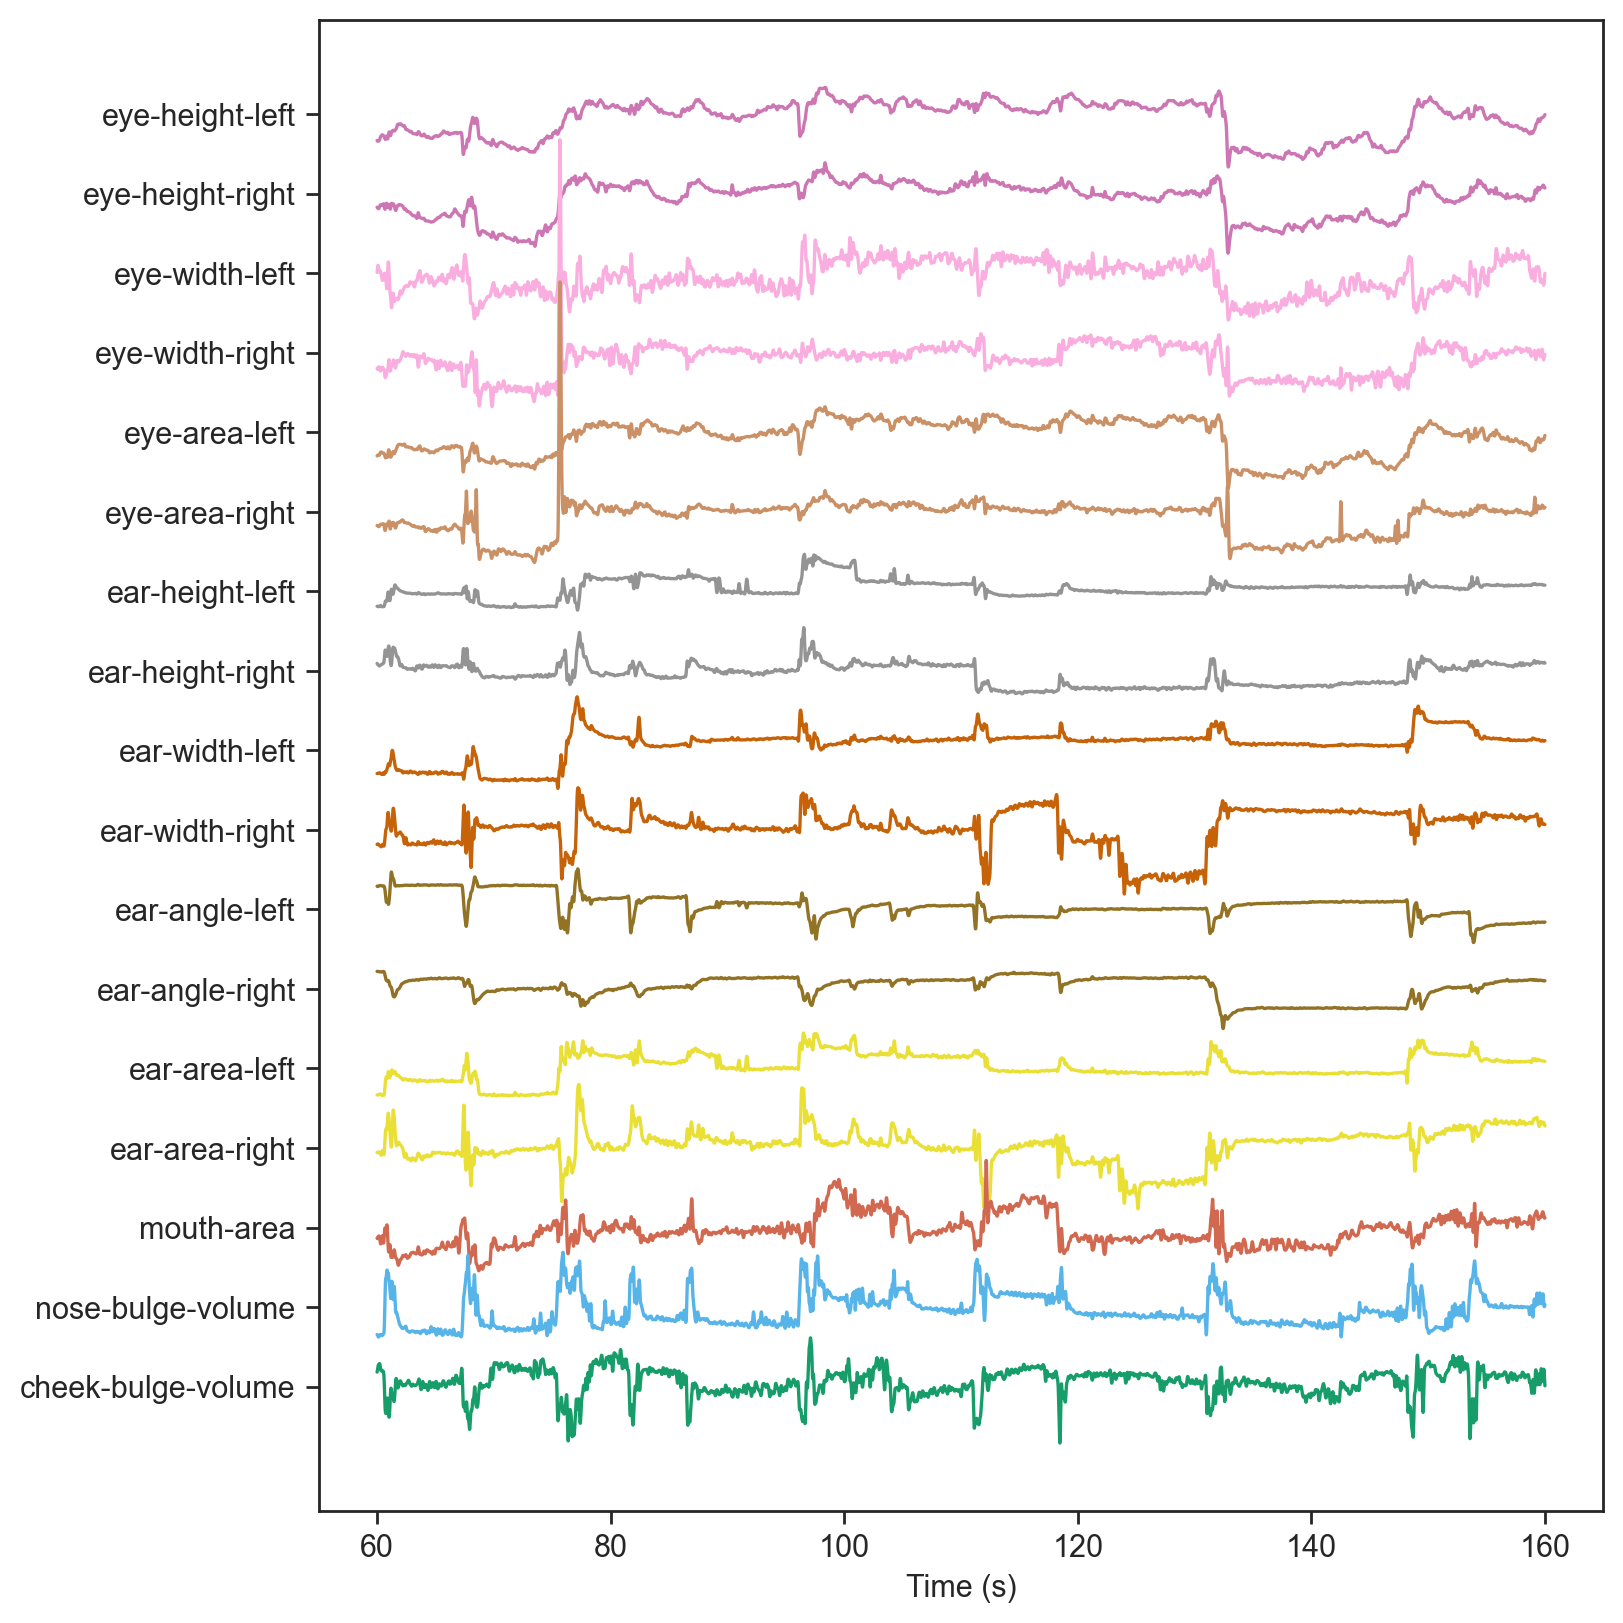

In [46]:
# Z SCORED DATA PER MEASUREMENT
fig, axs = plt.subplots(nrows=1,
                        ncols=1,
                        figsize=(8, 8),
                        dpi=200,
                        constrained_layout=True)

spacing = 0
spacer = 5 #8
y_labels = []
frame_bounds = (6000, 16001) # 3 seconds:(6600, 6901) # 3 s (b): (10000, 10300) # 30 seconds - periodic movement: (5000, 8001) # 100 s: (6000, 16001) # 10 s: (10000, 11001) # 10 s (b): (12000, 13001)
twindow =  np.arange(*frame_bounds, 1) #np.arange(6700,7001, 1)
for a in meas_times_B6.keys():
    for l in meas_times_B6[a].keys():
        # print(l)
        spacing +=1 
        plt.plot(timev[twindow], z_score(meas_times_B6[a][l])[twindow] - spacer*spacing, color = LANDMARK_CMAP_MEAS[1][l])
        y_labels.append(l)

axs.set_xlabel('Time (s)')
axs.set_yticks(np.arange(-spacer,-(spacer*spacing+1), -spacer)) #Negative signs to invert the order of measurements top-bottom
axs.set_yticklabels(y_labels);

file_name = f'meas_traces_B6_structure_awake_{int((frame_bounds[1]-frame_bounds[0])/100)}s_b'
# fig.savefig(f'{file_name}_ZSCORED.svg')
# fig.savefig(f'{file_name}_ZSCORED.png')

## Panel i

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


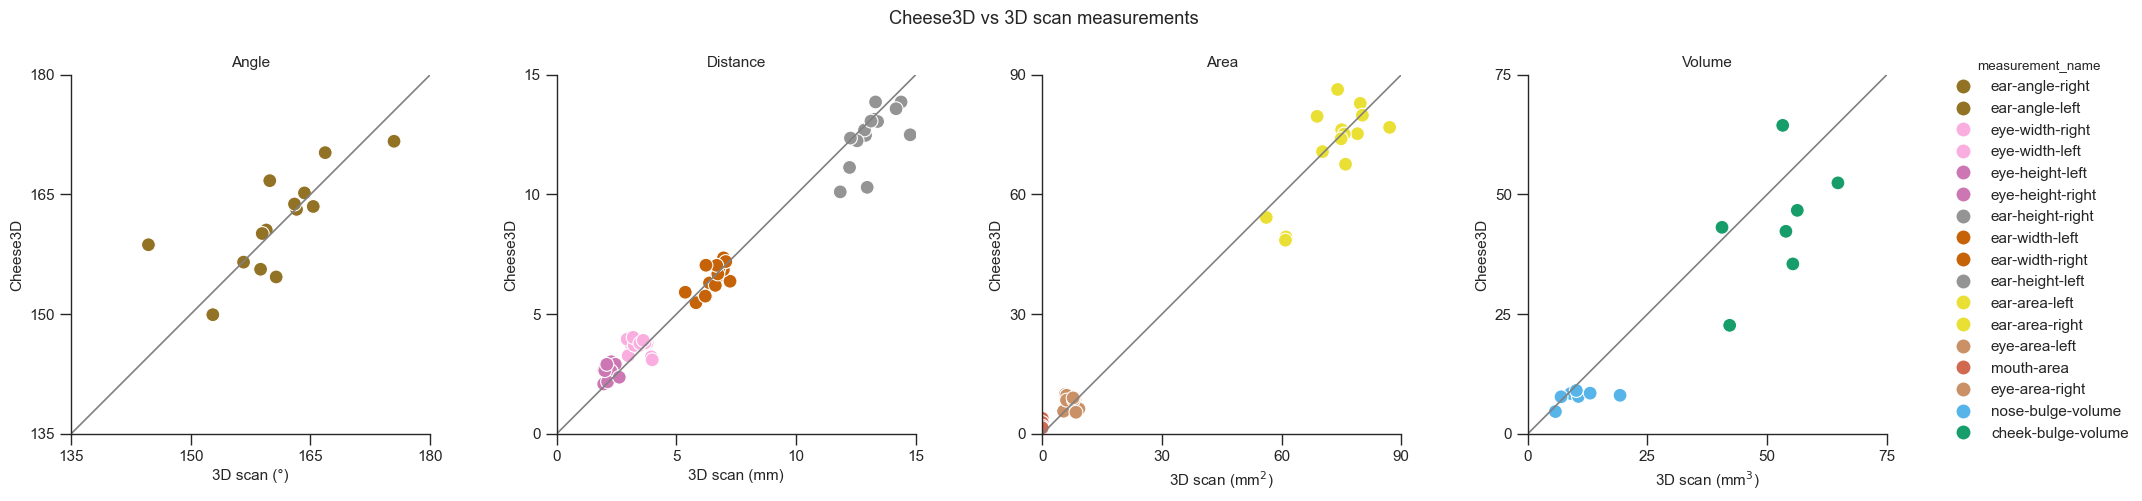

In [33]:
# By measurement unit (distance, area, volume):
plot_df = rig2_and_mesh_df#.query("measurement_name != ['ear-angle-left', 'ear-angle-right']")
# plt.rcParams['xtick.major.size'] = 20
# plt.rcParams['xtick.major.width'] = 4
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['xtick.bottom'] = True # Note these variables will affect all the plots (beyond this cell)
plt.rcParams['ytick.left'] = True
rp = sns.relplot(data=plot_df.sort_values('measurement_units').query("mouse != 'B21'"),
                 x='measurement_value_mesh',
                 y='measurement_value_rig2',
                 hue='measurement_name',
                 col='measurement_type',
                 palette=LANDMARK_CMAP_MEAS[1],
                 legend=True,
                 facet_kws=dict(sharex=False, sharey=False),
                )
rp.fig.suptitle('Cheese3D vs 3D scan measurements')
rp.fig.subplots_adjust(top=0.85) 

limits = {
    'area': (0, 90),
    'distance': (0, 15),
    'volume': (0, 75),
    'angle': (135, 180)
}
units = {
    'area': 'mm$^2$',
    'distance': 'mm',
    'volume': 'mm$^3$',
    'angle': u'\N{DEGREE SIGN}'
}

rp.set(ylabel='Cheese3D')
plt.legend(frameon=False)

for ax in rp.axes.flat:
    label = ax.title.get_text().split(' ')[-1]
    ax.title.set_text(label.capitalize())
    ax.set(xlabel=f"3D scan ({units[label]})")
    ax.set(xlim=limits[label], ylim=limits[label])
    #ax.set_yticks(np.arange(0,limits[label][1],(limits[label][1]//4)))
    _range = (limits[label][0], limits[label][1])
    ax.plot(_range, _range, color='gray') # Draw x==y line
    ax.set_xticks(np.linspace(*_range,4))
    ax.set_yticks(np.linspace(*_range,4))
    ax.set_aspect('equal')

# Uncomment lines below to save the figure in .png and .svg formats
# rp.savefig("./scatter-plots/structure_6camRig2_3Dmesh_perMeasurementUnit_plusAngle.png")
# rp.savefig("./scatter-plots/structure_6camRig2_3Dmesh_perMeasurementUnit_plusAngle.svg")